In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as inter
from scipy import optimize as opt
plt.rcParams['text.usetex'] = True
import bilby
from astropy import constants as const
from astropy import units as u
import math 

In [3]:
def alpha_core(eos_num, rhoc, draw_dir, eos_per_dir):
    eos = eos_num.astype(int)
    DRAWmod = eos//(eos_per_dir)
    
    eos_data = pd.read_csv(f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod:06}/eos-draw-{eos:06}.csv')
    P_only = np.array(eos_data['pressurec2'])
    ep_only = np.array(eos_data['energy_densityc2'])
    bp_only = np.array(eos_data['baryon_density'])
    
    bp_only += bp_only * np.arange(len(bp_only)) * np.finfo(float).eps
    
    P_of_rho = inter.interp1d(bp_only, P_only, 'cubic')
    ep_of_rho = inter.interp1d(bp_only, ep_only, 'cubic')
    
    Pc = P_of_rho(rhoc)
    ec = ep_of_rho(rhoc)
    
    return (Pc/ec)

def single_file_DataGet(csv_path, args, functions):
    data = pd.read_csv(csv_path) 
    max_idx = data['M'].idxmax() + 1
    min_idx = np.where(data['M']>0.8)[0][0]
    data = data.iloc[range(min_idx, max_idx)]
    
    return([func(*[data[arg] for arg in args]) for func in functions], np.array(data['rhoc']))

In [162]:
def DataGet(n_eos, args, functions, draw_dir, post_file, eos_per_dir, return_dict = False, 
            seed = np.random.randint(1,2e16-1), criteria = lambda index, post_file : True, eos_to_use = []):

    returns = len(functions)
    if return_dict:
        Data_fine = {}
    else:
        Data_fine = np.empty([n_eos, returns, 200])
    alpha_c = np.empty((n_eos,200))
    posterior_data = pd.read_csv(f'{post_file}')
            
    if len(eos_to_use):
        DRAWmod = eos_to_use//(eos_per_dir)
        for i in range(n_eos):  
            data_path = f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod[i]:06}/macro-draw-{eos_to_use[i]:06}.csv'
            MacroData, rhoc = single_file_DataGet(data_path, args, functions)
            rhoc_fine = np.linspace(rhoc[0], rhoc[-1], 200)
            
            if return_dict:
                Data_fine[eos_to_use[i]] = {}
                
            for j in range(returns):
                interp_funcs.append(inter.interp1d(rhoc, MacroData[j][1], 'cubic'))
                        
                if return_dict:
                    Data_fine[eos_to_use[i]][MacroData[j][0]] = interp_funcs[j](rhoc_fine)
                else:
                    Data_fine[i, j, :] = interp_funcs[j](rhoc_fine)
        
    else:
        np.random.seed(seed)
    
        indeces = np.zeros(n_eos)
        
        eos_num = np.array(posterior_data['eos'])
        
        i = 0
        while i < n_eos:
            index = np.random.choice(np.arange(eos_num.size))
            interp_funcs = []
        
            if (criteria(index, posterior_data) and (index not in indeces)):
                eos = eos_num[index].astype(int) 
                DRAWmod = eos//(eos_per_dir)
            
                data_path = f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod:06}/macro-draw-{eos:06}.csv'
                MacroData, rhoc = single_file_DataGet(data_path, args, functions)
                rhoc_fine = np.linspace(rhoc[0], rhoc[-1], 200)
            
                if return_dict:
                    Data_fine[eos] = {}
            
                for j in range(returns):
                    interp_funcs.append(inter.interp1d(rhoc, MacroData[j][1], 'cubic'))
                        
                    if return_dict:
                        Data_fine[eos][MacroData[j][0]] = interp_funcs[j](rhoc_fine)
                    else:
                        Data_fine[i, j, :] = interp_funcs[j](rhoc_fine)
                
            
                alpha_c[i,:] = alpha_core(eos, rhoc_fine, draw_dir, eos_per_dir)
            
                indeces[i] = index
                i+=1 
    
          
    return(Data_fine, alpha_c)

In [256]:
def Prediction(FullData, predict_forms, func, arg, n_param, sigma):
    n_eos = len(FullData)
    n_data = n_eos * len(sigma)
    
    A =  np.empty((n_param, n_data))
    
    var_dep = FullData[:,func,:]/sigma
    var_ind = FullData[:,arg,:]        
    
    b = var_dep.flatten()
    Ai_data = var_ind.flatten()
    
    sigma_repeating = np.tile(sigma, n_eos)
    for i in range(n_param):
            A[i] = (predict_forms(Ai_data,i)/sigma_repeating)
    sol = opt.lsq_linear(np.transpose(A), b)
    return(sol)

In [256]:
def Prediction(FullData, predict_forms, func, arg, n_param, sigma):
    n_eos = len(FullData)
    n_data = n_eos * len(sigma)
    
    A =  np.empty((n_param, n_data))
    
    var_dep = FullData[:,func,:]/sigma
    var_ind = FullData[:,arg,:]        
    
    b = var_dep.flatten()
    Ai_data = var_ind.flatten()
    
    sigma_repeating = np.tile(sigma, n_eos)
    for i in range(n_param):
            A[i] = (predict_forms(Ai_data,i)/sigma_repeating)
    sol = opt.lsq_linear(np.transpose(A), b)
    return(sol)

In [305]:
Cmpct = lambda M, R : np.array(M)/np.array(R)
functions = [lambda M, R, Lambda, Inertia  : ("M", np.array(M)[:]*1.477),
             lambda M, R, Lambda, Inertia  : ("R", np.array(R)[:]),
             lambda M, R, Lambda, Inertia  : ("Lambda", np.array(Lambda)[:]),
             lambda M, R, Lambda, Inertia  : ("Inertia", (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3)),
             lambda M, R, Lambda, Inertia  : ("C", Cmpct(M,R)[:]*1.477)]

# (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3))

statements = [lambda index, post_file : post_file['logweight_total'][index] > 0,
              lambda index, post_file : post_file['numbranch'][index] == 1]

def evaluate_criteria(index, post_data, statements):
    for statement in statements:
        if not(statement(index, post_data)):
            return False   
    return True

criteria = lambda index, post : evaluate_criteria(index, post, statements)

# seed = np.random.randint(1, 1000000)
# print(seed)

n_eos = 500

Data, a_c = DataGet(n_eos, ('M', 'R', 'Lambda', 'I'),functions,
                    '/home/philippe.landry/nseos/eos/gp/mrgagn',
                    '/home/isaac.legred/ParametricPaper/Analysis/corrected_np_all_post.csv',
                    1000, False, 966578, criteria)

In [302]:
Cmpct = lambda M, R : np.array(M)/np.array(R)
functions = [lambda M, R, Lambda, Inertia  : ("M", np.array(M)[:]*1.477),
             lambda M, R, Lambda, Inertia  : ("R", np.array(R)[:]),
             lambda M, R, Lambda, Inertia  : ("Lambda", np.array(Lambda)[:]),
             lambda M, R, Lambda, Inertia  : ("Inertia", (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3)),
             lambda M, R, Lambda, Inertia  : ("C", Cmpct(M,R)[:]*1.477)]

# (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3))

statements = [lambda index, post_file : post_file['logweight_total'][index] > 0]

criteria = lambda index, post : evaluate_criteria(index, post, statements)

seed = np.random.randint(1, 1000000)
print(seed)



Data, a_c = DataGet(n_eos, ('M', 'R', 'Lambda', 'I'),functions,
                    '/home/isaac.legred/',
                    '/home/isaac.legred/ParametricPaper/Analysis/corrected_np_all_post.csv',
                    100, False, seed, criteria)

SyntaxError: invalid syntax (2727798074.py, line 13)

 active_mask: array([0., 0., 0., 0., 0.])
        cost: 450.0616587058123
         fun: array([-0.08896356, -0.03877562, -0.06297132, ..., -0.00193526,
       -0.00199464, -0.00205484])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 6.221747753443196e-05
      status: 3
     success: True
           x: array([ 5.40379215, -0.8809609 ,  0.5882828 , -0.08169728,  0.0067272 ])


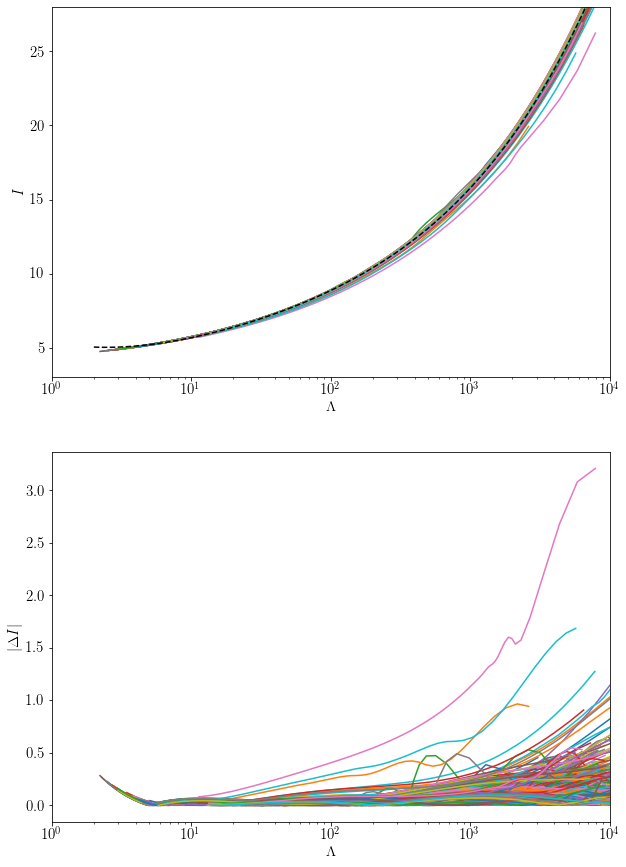

In [333]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)

solution = Prediction(Data, fs, 3, 2, 5, sig)
alpha = solution.x
delta = np.reshape(solution.fun, (n_eos, 200))
print(solution)

fig, axs = plt.subplots(2, figsize=(10, 15))

test_lambda = np.geomspace(2, 10000, 200)
# for i in range(len(test_lambda)):
#     test_I[i] = alpha[0] + (alpha[1] * (np.log(test_lambda[i]))) + (alpha[2] * (np.log(test_lambda[i]))**2)
#     + (alpha[3] * (np.log(test_lambda[i]))**3) + (alpha[4] * (np.log(test_lambda[i]))**4) 
    
# for i in range(len(test_lambda)):
#     test_I[i] = alpha[0] + alpha[1] * (np.log(test_lambda[i])) + alpha[2] * (np.log(test_lambda[i]))**2
    
test_I = np.sum([alpha[i] * fs(test_lambda, i) for i in range(len(alpha))], axis=0)  

# print(test_I)
# print(Data[np.random.choice(np.arange(len(Data))),3])

axs[0].plot(test_lambda, test_I, 'k--', zorder=1000)

for i in range(n_eos):
    axs[0].plot(Data[i,2],Data[i, 3])
    axs[1].plot (Data[i,2], np.abs(delta[i]))
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set(xlabel=r'$\Lambda$')
    ax.set_xlim([1,10000])
    
axs[0].set(ylabel=r'$I$')
axs[1].set(ylabel = r'$|\Delta I|$')

axs[0].set_ylim([3,28])

# axs[1].set_yscale('log')

plt.savefig('I_vs_Lambda.pdf')

 active_mask: array([0., 0., 0.])
        cost: 1.6227676858026296
         fun: array([-0.00044387, -0.00049292, -0.00036342, ...,  0.0111572 ,
        0.01119635,  0.01102578])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 2.4003554699447704e-10
      status: 3
     success: True
           x: array([ 0.36798483, -0.038654  ,  0.00096143])


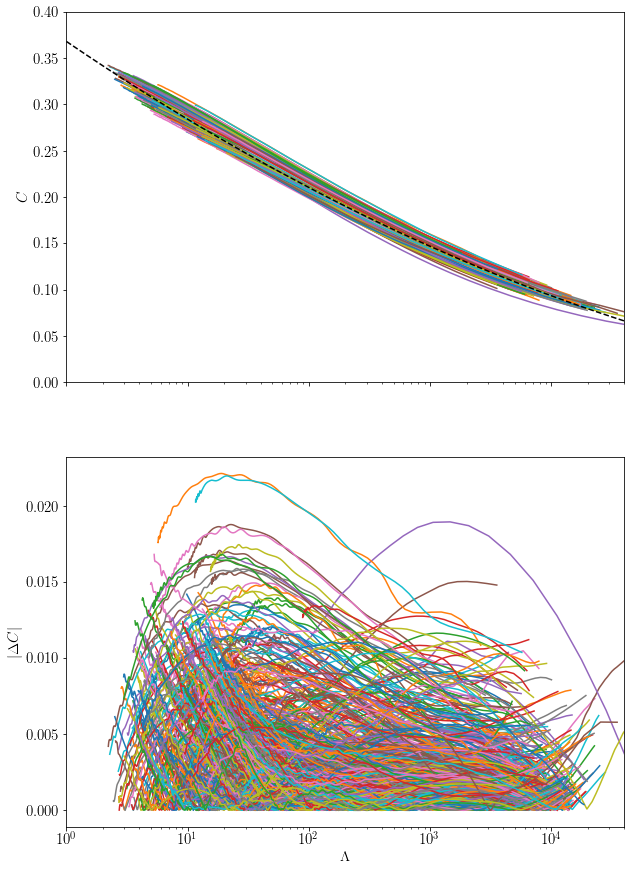

In [331]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)

solution = Prediction(Data, fs, 4, 2, 3, sig)
alpha = solution.x
delta = np.reshape(solution.fun, (500, 200))
print(solution)

fig, axs = plt.subplots(2, figsize=(10, 15), sharex=True)

test_lambda = np.geomspace(1, 40000, 200)
test_C = np.zeros(len(test_lambda))
# for i in range(len(test_lambda)):
#     test_C[i] = alpha[0] + (alpha[1] * (np.log(test_lambda[i]))) + (alpha[2] * (np.log(test_lambda[i]))**2)
#     + (alpha[3] * (np.log(test_lambda[i]))**3) + (alpha[4] * (np.log(test_lambda[i]))**4) 
    
for i in range(len(test_lambda)):
    test_C[i] = alpha[0] + alpha[1] * (np.log(test_lambda[i])) + alpha[2] * (np.log(test_lambda[i]))**2

# print(test_I)
# print(Data[np.random.choice(np.arange(len(Data))),3])

axs[0].plot(test_lambda, test_C, 'k--', zorder=1000)

for i in range(500):
    axs[0].plot(Data[i,2],Data[i, 4])
    axs[1].plot (Data[i,2], np.abs(delta[i]))
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([1,40000])
    
axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$C$')
axs[1].set(ylabel = r'$|\Delta C| $')

axs[0].set_ylim([0,0.4])

plt.savefig('C_vs_Lambda.pdf')

 active_mask: array([0., 0., 0.])
        cost: 40949.191447802754
         fun: array([0.45347983, 0.41559703, 0.375613  , ..., 0.92301626, 0.92927129,
       0.94425771])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 1.8475475371815264e-08
      status: 3
     success: True
           x: array([10.39455051,  0.63726925, -0.03651015])


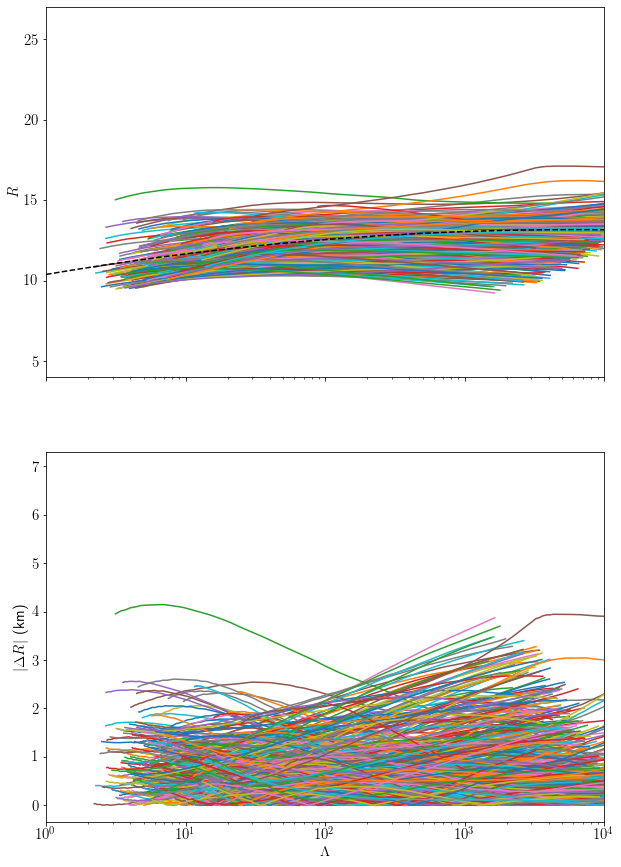

In [327]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)

solution = Prediction(Data, fs, 1, 2, 3, sig)
alpha = solution.x
delta = np.reshape(solution.fun, (n_eos, 200))
print(solution)

fig, axs = plt.subplots(2, figsize=(10, 15), sharex=True)

test_lambda = np.geomspace(1, 10000, 200)
test_R = np.zeros(len(test_lambda))
# for i in range(len(test_lambda)):
#     test_C[i] = alpha[0] + (alpha[1] * (np.log(test_lambda[i]))) + (alpha[2] * (np.log(test_lambda[i]))**2)
#     + (alpha[3] * (np.log(test_lambda[i]))**3) + (alpha[4] * (np.log(test_lambda[i]))**4) 
    
for i in range(len(test_lambda)):
    test_R[i] = alpha[0] + alpha[1] * (np.log(test_lambda[i])) + alpha[2] * (np.log(test_lambda[i]))**2

# print(test_I)
# print(Data[np.random.choice(np.arange(len(Data))),3])

axs[0].plot(test_lambda, test_R, 'k--', zorder=10000)

for i in range(n_eos):
    axs[0].plot(Data[i,2], Data[i, 0]/Data[i,4])
    axs[1].plot (Data[i,2], np.abs(delta[i]))
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([1,10000])
    
axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$R$')
axs[1].set(ylabel = r'$|\Delta R|$ (km)')

axs[0].set_ylim([4,27])

plt.savefig('R_vs_Lambda.pdf')

In [336]:
import subprocess 

p = subprocess.run("whoami")
p = subprocess.run("hostname")


oscar.sy-garcia
ldas-pcdev5


In [365]:
def find_nearest(array,value):
    diff_arr = np.abs(array - value)
    idx = diff_arr.argmin()
    return(idx)

def Lambda_a_s(Data, q, Mass_idx,Lambda_idx):
    Mass_Data = Data[:,Mass_idx,:]
    Lambda_Data = Data[:,Lambda_idx,:]
    n_eos = len(Mass_Data)
    Lambda_A_tot = [[] for i in range(n_eos)]
    Lambda_S_tot = [[] for i in range(n_eos)]
    for i in range(n_eos):
        lam_a = []
        lam_s = []
        j = 0
        while (Mass_Data[i,-1-j]*q >= Mass_Data[i,0]):
            m1_idx = -1 - j
            lam_1 = Lambda_Data[i, m1_idx]
            
            m2_idx = find_nearest(Mass_Data[i], q * Mass_Data[i,m1_idx])

            lam_2 = Lambda_Data[i, m2_idx]
            lam_a.append(np.abs((lam_1 - lam_2)*0.5))
            lam_s.append((lam_1 + lam_2)*0.5)
            j += 1
        Lambda_A_tot[i] = lam_a
        Lambda_S_tot[i] = lam_s
    return(Lambda_A_tot, Lambda_S_tot)

def Lambda_pred(lam_a, lam_s, predict_form, n_param):
    

[1.18267224 1.22086218 1.25860697 1.29604261 1.3333051  1.37053045
 1.40784499 1.44532246 1.48301766 1.52092749 1.5589621  1.59701817
 1.63494448 1.672568   1.70971114 1.74618741 1.7818126  1.81643724
 1.84993287 1.88219743 1.9131978  1.94291348 1.97134572 1.99851292
 2.02444073 2.04917889 2.0727827  2.09531178 2.11683021 2.13740026
 2.15707423 2.1759015  2.19393404 2.21122742 2.22783532 2.24379759
 2.25914844 2.27392499 2.28816947 2.30192339 2.31521633 2.32807137
 2.34051219 2.35256404 2.36425226 2.37560092 2.38663313 2.39736995
 2.40782599 2.41801464 2.42795124 2.43765288 2.44713604 2.45641415
 2.46549981 2.47440518 2.48314193 2.49172157 2.50015488 2.5084524
 2.51662438 2.5246807  2.53263092 2.54048241 2.54824146 2.55591769
 2.56352774 2.57108834 2.57860653 2.5860831  2.59352024 2.60092436
 2.60830248 2.61566014 2.62300153 2.63033104 2.63765399 2.64497589
 2.65230218 2.65963819 2.66699016 2.67436914 2.6817875  2.68924519
 2.69672418 2.70420684 2.7116884  2.71916981 2.72665445 2.73415

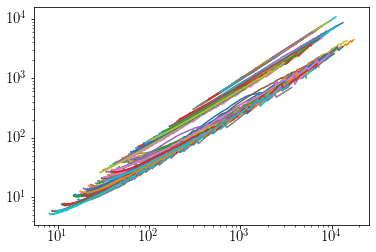

In [374]:
print(Data[200,0])
lam_a_5, lam_s_5 = Lambda_a_s(Data, 0.5, 0, 2)
lam_a_75, lam_s_75 = Lambda_a_s(Data, 0.75, 0, 2)
lam_a_9, lam_s_9 = Lambda_a_s(Data, 0.9, 0, 2)

fig, ax = plt.subplots()

for i in range(n_eos//10):
    ax.plot(lam_s_5[i], lam_a_5[i])
    ax.plot(lam_s_75[i], lam_a_75[i])
    ax.plot(lam_s_9[i], lam_a_9[i])
    
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,2],Data[i, 4])
    
# def test_C(lam):
#     Compact1 = np.zeros(len(lam))
#     Compact2 = np.zeros(len(lam))
#     for i in range(len(lam)):
#         Compact1[i] = 0.371 - (0.0391 * (np.log(lam[i]))) + (0.001056 * (np.log(lam[i]))**2)
#         Compact2[i] = 0.360 - (0.0355 * (np.log(lam[i]))) + (0.000705 * (np.log(lam[i]))**2)
#     return(Compact1, Compact2)
# test_lambda = np.linspace(1, 10000, 500)
# test_C1, test_C2 = test_C(test_lambda)
# ax.plot(test_lambda, test_C1, 'k--', zorder=100)
# ax.plot(test_lambda, test_C2, 'k-', zorder=100)
    
# ax.set(xlabel=r'$\Lambda', ylabel=r'C')
# ax.set_xscale('log')
# #ax.set_ylim([0.05, 0.32])
# #ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('C-vs-Lambda.pdf')

In [140]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,4]*1.477,a_c[i])
# ax.set(xlabel='C', ylabel=r'$\alpha_c$')
# ax.set_xlim(left = 0.05)
# ax.set_yscale('log')
# ax.set_ylim([0.017,4])
# ax.grid(True, which = 'both')
# plt.savefig('alpha_c-vs-C')


2.3065009260633953e-44

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,2],Data[i, 1])
# ax.set(xlabel=r'$\Lambda$', ylabel=r'R (km)')
# ax.set_xscale('log')
# #ax.set_ylim([0.05, 0.32])
# ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('R-vs-Lambda')

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,1],Data[i, 0])
# ax.set(xlabel=r'R (km)', ylabel=r'Mass (Msun)')
# #ax.set_ylim([0.05, 0.32])
# #ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('M-vs-R')

In [7]:
def param_overall(FullData, predict_forms, idx1, idx2, n_param, sigma):
    n_eos = len(FullData)
    
    param_overall = np.empty((n_eos,n_param))
    var_dep = FullData[:,idx1,:]/sigma #data to acheieve
    var_ind = FullData[:,idx2,:]
    for i in range(n_eos):
        matrix = np.array([(predict_forms(var_ind[i,:],j)/sigma) for j in range(n_param)])
        sol = opt.lsq_linear(np.transpose(matrix),var_dep[i,:])
        param_overall[i,:] = sol.x
    return (param_overall)

In [182]:
#subData = Data[1]
#sol = Prediction(subData, fs, 4, 2, 3, sig)
#print(sol.x)

# param_overall = np.empty((500,3))
# for i in range(500):
#     subData = Data[i]
#     sol = Prediction(subData, fs, 4, 2, 3, sig)
#     param_overall[i,:] = sol.x
#     print(sol.fun)
# np.average(param_overall,axis=0)


fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,0.001)

solution = Prediction(Data, fs, 'C', 'Lambda', 3, sig, True)
print(solution.x)

dict_values([{'M': array([1.26519262, 1.32685707, 1.38596606, 1.44259462, 1.49681779,
       1.54871061, 1.5983481 , 1.64580676, 1.6911745 , 1.73454464,
       1.77601051, 1.81566521, 1.85360174, 1.88991297, 1.92468988,
       1.95802187, 1.98999799, 2.02069868, 2.05019466, 2.07855608,
       2.10585064, 2.13214231, 2.1574947 , 2.18196682, 2.20560834,
       2.22846776, 2.25059137, 2.27201928, 2.29279053, 2.312943  ,
       2.33251018, 2.35152451, 2.37001768, 2.38801756, 2.40555076,
       2.42264301, 2.43931365, 2.45557912, 2.47145651, 2.48697023,
       2.50214914, 2.51702116, 2.53159818, 2.54587903, 2.55986279,
       2.57356607, 2.58702452, 2.60027434, 2.6133318 , 2.62618439,
       2.63881746, 2.65123315, 2.66346614, 2.67555483, 2.68752377,
       2.69936085, 2.711048  , 2.72257703, 2.73397572, 2.74528005,
       2.7565188 , 2.76768442, 2.77875791, 2.78972503, 2.80060573,
       2.81143473, 2.82224338, 2.83302791, 2.84376402, 2.85442935,
       2.86503543, 2.87562028, 2.88622136, 

TypeError: unhashable type: 'slice'

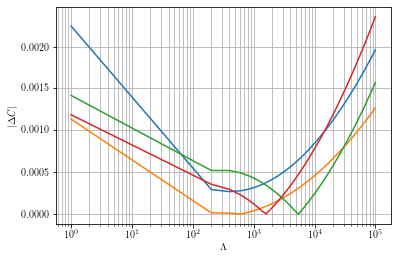

In [105]:
fig, ax = plt.subplots()

test_lambda = np.linspace(1, 100000, 500)
test_C1 = np.zeros(len(test_lambda))
test_C2 = np.zeros(len(test_lambda))
test_C3 = np.zeros(len(test_lambda))
test_C4 = np.zeros(len(test_lambda))
test_C5 = np.zeros(len(test_lambda))
for i in range(len(test_lambda)):
    test_C1[i] = 0.36621088 - (0.03787991 * (np.log(test_lambda[i]))) + (0.00088979 * (np.log(test_lambda[i]))**2)
    test_C2[i] = 0.36845603 - (0.03854036 * (np.log(test_lambda[i]))) + (0.00094501 * (np.log(test_lambda[i]))**2)
    test_C3[i] = 0.36734559 - (0.03829281 * (np.log(test_lambda[i]))) + (0.00092667 * (np.log(test_lambda[i]))**2)
    test_C4[i] = 0.36762851 - (0.03856961 * (np.log(test_lambda[i]))) + (0.00095086 * (np.log(test_lambda[i]))**2)
    test_C5[i] = 0.36739782 - (0.038507 * (np.log(test_lambda[i]))) + (0.00095309 * (np.log(test_lambda[i]))**2)
    
ax.plot(test_lambda, np.abs(test_C2 - test_C1))
ax.plot(test_lambda, np.abs(test_C3 - test_C1))
ax.plot(test_lambda, np.abs(test_C4 - test_C1))
ax.plot(test_lambda, np.abs(test_C5 - test_C1))

ax.set(xlabel=r'$\Lambda$', ylabel=r'$|\Delta C|$')
ax.set_xscale('log')
ax.grid(True, which = 'both')
plt.savefig('C-vs-Lambda_fit.pdf')

In [91]:
def M_of_Lambda(C_L_param, Lambda, fs):
    Mparam = (C_L_param * 12)/1.477
    Mass = np.sum([Mparam[i]*fs(Lambda,i) for i in range(len(C_L_param))],axis = 0) 
    return(Mass)

In [40]:
Lambda = np.geomspace(10,10000,100)
M = M_of_Lambda(solution.x, Lambda, fs)

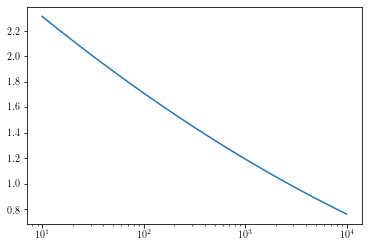

In [36]:
fig, ax = plt.subplots()
ax.plot(Lambda, M)
ax.set_xscale('log')

In [92]:
M_op = M_of_Lambda(solution.x , 500, fs)

In [93]:
bilby.gw.conversion.component_masses_to_chirp_mass(M_op,M_op)

1.166324158248777

In [94]:
Lambda = [20,30,50,200,300,500,700,1000]
M_chirp = np.empty(len(Lambda))
for i,o in enumerate(Lambda):
    M_op = M_of_Lambda(solution.x, o, fs)
    M_chirp[i] = bilby.gw.conversion.component_masses_to_chirp_mass(M_op,M_op)
M_chirp

array([1.84314752, 1.75020179, 1.63625928, 1.34476732, 1.26440874,
       1.16632416, 1.10363932, 1.03885729])

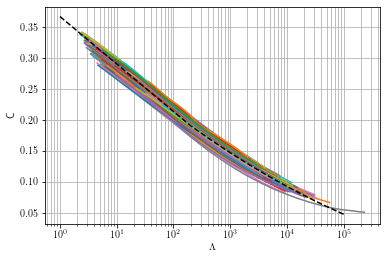

In [78]:
fig, ax = plt.subplots()
for i in range(500):
    ax.plot(Data[i,2],Data[i, 4])
test_lambda = np.linspace(1, 100000, 500)
test_C = np.zeros(len(test_lambda))
for i in range(len(test_lambda)):
    test_C[i] = 0.36621088 - (0.03787991 * (np.log(test_lambda[i]))) + (0.00088979 * (np.log(test_lambda[i]))**2)
ax.plot(test_lambda, test_C, 'k--', zorder=1000)
ax.set(xlabel=r'$\Lambda$', ylabel=r'C')
ax.set_xscale('log')
ax.grid(True, which = 'both')
plt.savefig('C-vs-Lambda.pdf')

In [100]:
print((const.c**4/(const.G**2 * u.kg**3))*((1000 * u.kg * u.m**2)/(u.g * 100 * u.cm**2)))

1.8133071098665124e+55 1 / (cm2 g)


In [99]:
print(const.c**4/(const.G**2 * u.kg**3))

1.8133071098665124e+54 1 / (kg m2)
